In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma, gammainc
import math
import pickle
from scipy.spatial.distance import cdist
import plotly.graph_objects as go
import pandas as pd

In [2]:
def path_loss(d, f=2.4): # d is in kilometre
    return 20 * np.log10(d) + 20 * np.log10(f) + 92.45

def convert_dBm_W(P):
    return 10**((P-30) / 10)

def convert_dB_W(P):
    return 10**((P) / 10)

def watts_to_dB(P):
    return 10 * np.log10(P)

In [3]:
noise = 1e-13
h_uu = 0.5
rho = 1e-10
tau = 1
relay_num = 20 #5, 10, 20, 30
uav_h = 2

In [4]:
from adjustText import adjust_text  # Import adjustText library

def generate_map(relay_num, random_seed=600):
    # Fixed points
    source = np.array([[0, 0]])
    destination = np.array([[2, 2]])

    # Parameters
    map_size = 2  # Map boundary

    # Generate unique random seed for each relay based on its index
    np.random.seed(random_seed)  # Set base seed for reproducibility
    relay_points = []

    uav_point = np.random.rand(1, 2) * map_size
    
    for i in range(relay_num):
        # Set each relay's seed based on its index
        np.random.seed(random_seed + 1 + i)
        relay_points.append([(np.random.rand(1) * map_size)[0], (np.random.rand(1) * map_size)[0]])
    
    relay_points = np.vstack(relay_points)

    # Combine all points
    all_points = np.vstack([source, relay_points, uav_point, destination])
    labels = ['Source'] + [f'Relay{i+1}' for i in range(relay_num)] + ['UAV', 'Destination']

    # Plot
    plt.figure(figsize=(8, 8))
    plt.scatter(source[:, 0], source[:, 1], c='green', label='Source', marker='s', s=30)
    plt.scatter(destination[:, 0], destination[:, 1], c='red', label='Destination', marker='s', s=30)
    plt.scatter(relay_points[:, 0], relay_points[:, 1], c='blue', label='Relays', marker='o')
    plt.scatter(uav_point[:, 0], uav_point[:, 1], c='orange', label='UAV', marker='^', s=30)

    # Annotate with dynamic label adjustment
    texts = []
    for i, (x, y) in enumerate(all_points):
        text = plt.text(x + 0.05, y + 0.05, labels[i], fontsize=9)
        texts.append(text)
    
    # Use adjustText to adjust the positions of the labels
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

    plt.xlim(-0.25, map_size + 0.25)
    plt.ylim(-0.25, map_size + 0.25)
    plt.grid(True)

    # Place the legend in the top-right corner
    plt.legend(loc='upper left', fontsize=10)

    plt.title('Map of Source, Relays, UAV, and Destination')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.savefig('HD Map.png', dpi=600, bbox_inches='tight')

    plt.show()

    dist_matrix = cdist(all_points, all_points)

    idx_source = 0
    idx_relays_start = 1
    idx_relays_end = idx_relays_start + relay_num
    idx_uav = idx_relays_end
    idx_destination = idx_uav + 1

    # Extract required distances
    d_s_ri = dist_matrix[idx_source, idx_relays_start:idx_relays_end]      # Source to each relay
    d_u_ri = (np.array(dist_matrix[idx_uav, idx_relays_start:idx_relays_end])**2 + uav_h**2)**0.5         # UAV to each relay
    d_ri_u = d_u_ri
    d_ri_d = dist_matrix[idx_relays_start:idx_relays_end, idx_destination] # Each relay to Destination
    d_u_s = (dist_matrix[idx_uav, idx_source]**2 + uav_h**2)**0.5                               # UAV to Source
    d_u_d = (dist_matrix[idx_uav, idx_destination]**2 + uav_h**2)**0.5    

    n = relay_num + 1
    
    pl_s_u = path_loss(d_u_s)                          # Path loss from source to UAV
    pl_ri_u = np.array([path_loss(d) for d in d_ri_u])
    pl_u_ri = pl_ri_u
    pl_s_ri = np.array([path_loss(d) for d in d_s_ri])
    pl_ri_d = np.array([path_loss(d) for d in d_ri_d])  # Path loss from relay to destination
    pl_u_d = path_loss(d_u_d)            

    return d_s_ri, d_u_ri, d_ri_u, d_ri_d, d_u_s, d_u_d, n, pl_s_u, pl_ri_u, pl_u_ri, pl_s_ri, pl_ri_d, pl_u_d


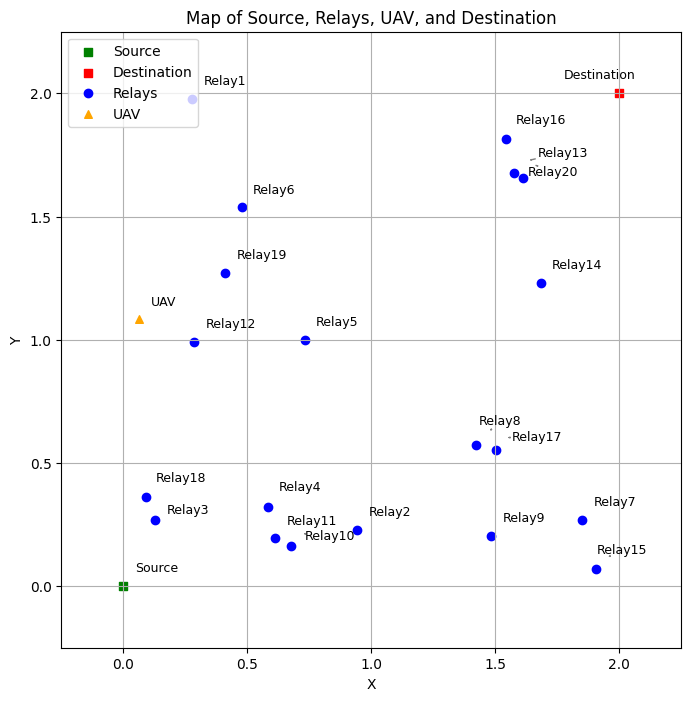

In [5]:
d_s_ri, d_u_ri, d_ri_u, d_ri_d, d_u_s, d_u_d, n, pl_s_u, pl_ri_u, pl_u_ri, pl_s_ri, pl_ri_d, pl_u_d = generate_map(relay_num=relay_num)

In [6]:
np.random.gamma(2, 1/2, 10)

array([0.56094989, 0.14461547, 0.97064151, 0.77637395, 0.28821365,
       0.4329849 , 0.90667032, 0.65447135, 0.10215546, 0.14179813])

In [7]:
pl_s_u = convert_dB_W(pl_s_u)
pl_ri_u = convert_dB_W(pl_ri_u)
pl_u_ri = convert_dB_W(pl_u_ri)
pl_s_ri = convert_dB_W(pl_s_ri)
pl_ri_d = convert_dB_W(pl_ri_d)
pl_u_d = convert_dB_W(pl_u_d)

In [8]:
pl_ri_d

array([3.00582754e+10, 4.31120863e+10, 6.58645560e+10, 4.87918400e+10,
       2.64086611e+10, 2.56648242e+10, 3.06128984e+10, 2.40334028e+10,
       3.54188185e+10, 5.18840371e+10, 5.24971391e+10, 4.00067637e+10,
       2.88469756e+09, 7.01263082e+09, 3.78777302e+10, 2.47251843e+09,
       2.37152266e+10, 6.41746366e+10, 3.09010008e+10, 2.70144015e+09])

In [9]:
P_u_start = 25
P_u_end = 45
P_x_start = 25
P_x_end = 45

In [10]:
# Phase 1 Outage Probability
def phase1_outage_prob(P_s, P_u, m_relay = 2, m_source = 2, num_samples = 10000):
    P_s = convert_dBm_W(P_s)
    P_u = convert_dBm_W(P_u)
    
    theta_s_ri = np.array([P_s / pl for pl in pl_s_ri])    # Source to relay
    theta_u_ri = np.array([P_u / pl for pl in pl_u_ri])    # UAV to relay

    print('Generating Gamma random variables.')

    h_s_ri = np.array([np.random.gamma(m_relay, 1/m_relay, num_samples) for i in range(relay_num)])
    h_u_ri = np.array([np.random.gamma(m_relay, 1/m_relay, num_samples) for i in range(relay_num)])
    
    SINRs = []
    for ri in range(relay_num):
        SINR = (P_s * h_s_ri[ri] / pl_s_ri[ri]) / (noise + P_u * h_u_ri[ri] / pl_u_ri[ri]) 
        SINRs.append(SINR)
    SINRs = np.array(SINRs)
    # return SINRs
    return np.array([np.mean(i < tau) for i in SINRs]) 

# Phase 2 Outage Probability
def phase2_outage_prob(P_ri, P_u, m_relay = 2, m_source = 2, num_samples = 10000):
    P_ri = convert_dBm_W(P_ri)
    P_u = convert_dBm_W(P_u)
 
    theta_ri_d = np.array([P_ri / pl for pl in pl_ri_d])   # Source to relay
    theta_u_d = P_u / pl_u_d     # UAV to relay

    print('Generating Gamma random variables.')

    h_ri_d = np.array([np.random.gamma(m_relay, 1/m_relay, num_samples) for i in range(relay_num)])
    h_u_d = np.random.gamma(m_relay, 1/m_relay, num_samples)

    SINRs = []
    for ri in range(relay_num):
        SINR = (P_ri * h_ri_d[ri] / pl_ri_d[ri]) / (noise + P_u * h_u_d / pl_u_d) 
        # SINR = (P_ri * h_ri_d[ri] / pl_ri_d[ri]) / (noise + P_u * h_u_d / pl_u_d) 
        SINRs.append(SINR)
    SINRs = np.array(SINRs)

    return np.array([np.mean(i < tau) for i in SINRs]) 

def e2e_succ_prob(P_s, P_ri, P_u, m_relay = 2, m_source = 2, num_samples = 10000):
    phase1_succ_i = 1 - phase1_outage_prob(P_s, P_u, m_relay, m_source, num_samples)
    phase2_succ_i = 1 - phase2_outage_prob(P_ri, P_u, m_relay, m_source, num_samples)

    both_phase_succ_i = phase1_succ_i * phase2_succ_i

    e2e_succ = 1 - np.prod(1 - both_phase_succ_i)

    return e2e_succ

In [11]:
# P_succ_3d = []
# for P_x in range(P_x_start*10, P_x_end*10+1):
#     temp = []
#     P_x = P_x / 10
#     for P_u in range(P_u_start*10, P_u_end*10+1):
#         P_u = P_u / 10
#         print(f'P_x = {P_x}, P_u = {P_u} \n')
        
#         succ_proc = e2e_succ_prob(P_x, P_x, P_u)
#         temp.append(succ_proc)
#     P_succ_3d.append(temp)
    
# with open(f'checkpoint_succ_{relay_num}_relay.pkl', 'wb') as f:
#     pickle.dump(P_succ_3d, f)


In [12]:
def math_detection_prob(P_x, P_u, chosen_r, m_relay = 2, m_source = 2, tau = 1, loops = 100):
    P_s = P_x 
    P_ri = P_x 

    theta_s_u = 1 / m_source     
    theta_ri_u = 1 / m_relay   

    beta_s_u = theta_s_u * P_s / pl_s_u      # Source to UAV
    beta_ri_u = (theta_ri_u * P_ri / pl_ri_u)[chosen_r]  # Relay to UAV

    beta_min = min([beta_s_u, beta_ri_u])

    coef = np.prod([(beta_min / beta_ri_u)**m_relay, (beta_min / beta_s_u)**m_source])

    sigmas = [1]
    for k in range(1, loops):
        epsilons = []
        for j in range(1, k+1):
            epsilon = 0
            epsilon += (m_relay/j) * ((1 - beta_min / beta_ri_u)**j)
            epsilon += (m_source/j) * ((1 - beta_min / beta_s_u)**j)
            epsilons.append(epsilon)
        sigma = (1/k) * sum([j * epsilons[j-1] * sigmas[k-j] for j in range(1, k+1)])
        sigmas.append(sigma)
    res = []
    lambda_ = rho * P_u * h_uu

    tau = tau * lambda_
    P_detection_cdf = 1 - (coef * sum([sigmas[k] * gammainc((m_source + m_relay) + k, tau/beta_min) for k in range(len(sigmas))]))
    return P_detection_cdf

m_relay = 2
m_source = 2
num_samples = 10**7
h_ri_u = np.array(np.random.gamma(m_relay, 1/ m_relay, num_samples))
h_s_u = np.array(np.random.gamma(m_source, 1/ m_source, num_samples))

def sim_detection_prob(P_x, P_u, chosen_r, m_relay = 2, m_source = 2, num_samples = 10**7):
    P_s = P_x #dBm
    P_ri = P_x  # Power at relay
    
    numerator = 0

    numerator += P_s * h_s_u / pl_s_u
    numerator += P_ri * h_ri_u / pl_ri_u[chosen_r]

    temp = numerator / (noise + rho * P_u * h_uu) 
    return np.mean(temp > tau)

In [13]:
import time
def choose_relay(P_x, P_u, m_relay = 2):
    P_x = convert_dBm_W(P_x)
    P_u = convert_dBm_W(P_u)
    P_s = P_x 
    P_ri = P_x  

    h_ri_d = np.array([np.random.gamma(m_relay, 1/m_relay, 1) for i in range(relay_num)])
    h_u_d = np.random.gamma(m_relay, 1/m_relay, 1)

    SINRs = []
    for ri in range(relay_num):
        SINR = (P_ri * h_ri_d[ri] / pl_ri_d[ri]) / (noise + P_u * h_u_d / pl_u_d) 
        SINRs.append(SINR)
    chosen_r = SINRs.index(max(SINRs))
    return chosen_r


In [14]:
# Phase 1 Outage Probability
def phase1_SINR(P_s, P_u, m_relay = 2, m_source = 2, num_samples = 10000):
    P_s = convert_dBm_W(P_s)
    P_u = convert_dBm_W(P_u)
    
    theta_s_ri = np.array([P_s / pl for pl in pl_s_ri])    # Source to relay
    theta_u_ri = np.array([P_u / pl for pl in pl_u_ri])    # UAV to relay

    h_s_ri = np.array([np.random.gamma(m_relay, 1/m_relay, num_samples) for i in range(relay_num)])
    h_u_ri = np.array([np.random.gamma(m_relay, 1/m_relay, num_samples) for i in range(relay_num)])
    
    SINRs = []
    for ri in range(relay_num):
        SINR = (P_s * h_s_ri[ri] / pl_s_ri[ri]) / (noise + P_u * h_u_ri[ri] / pl_u_ri[ri]) 
        SINRs.append(SINR)
    SINRs = np.array(SINRs)
    # return SINRs
    return SINRs

# Phase 2 Outage Probability
def phase2_SINR(P_ri, P_u, m_relay = 2, m_source = 2, num_samples = 10000):
    P_ri = convert_dBm_W(P_ri)
    P_u = convert_dBm_W(P_u)
 
    theta_ri_d = np.array([P_ri / pl for pl in pl_ri_d])   # Source to relay
    theta_u_d = P_u / pl_u_d     # UAV to relay

    h_ri_d = np.array([np.random.gamma(m_relay, 1/m_relay, num_samples) for i in range(relay_num)])
    h_u_d = np.random.gamma(m_relay, 1/m_relay, num_samples)

    SINRs = []
    for ri in range(relay_num):
        SINR = (P_ri * h_ri_d[ri] / pl_ri_d[ri]) / (noise + P_u * h_u_d / pl_u_d) 
        # SINR = (P_ri * h_ri_d[ri] / pl_ri_d[ri]) / (noise + P_u * h_u_d / pl_u_d) 
        SINRs.append(SINR)
    SINRs = np.array(SINRs)

    return SINRs

In [15]:
def choose_relay_2(P_x, P_u):
    SINRs = list(zip(phase2_SINR(30,30,num_samples=1).reshape(-1), phase1_SINR(30,30,num_samples=1).reshape(-1)))
    min_SINRs = [min(i) for i in SINRs]
    return min_SINRs.index(max(min_SINRs))

In [16]:
chosen = pd.Series([choose_relay_2(30,30) for i in range(10)])
chosen.value_counts()

16    2
15    1
19    1
14    1
8     1
10    1
7     1
9     1
13    1
Name: count, dtype: int64

In [17]:
P_detection_3d_math = []
P_detection_3d_sim = []
for P_x in range(P_x_start*10, P_x_end*10 + 1):
    P_x = P_x / 10
    for P_u in range(P_u_start*10, P_u_end*10 + 1):
        P_u = P_u / 10
        print(P_x, P_u)
        temp_r = []
        for i in range(30):
            temp_r.append(choose_relay_2(P_x, P_u))
        chosen_relays = pd.Series(temp_r).value_counts().reset_index().values
        P_detection_math = 0
        P_detection_sim = 0
        for r, count in chosen_relays:
            P_detection_math += math_detection_prob(convert_dBm_W(P_x), convert_dBm_W(P_u), r) * count
            P_detection_sim += sim_detection_prob(convert_dBm_W(P_x), convert_dBm_W(P_u), r) * count

        P_detection_3d_math.append(P_detection_math/30)
        P_detection_3d_sim.append(P_detection_sim/30)  

with open(f'checkpoint_det_{relay_num}_relay_(math)_T.pkl', 'wb') as f:
    pickle.dump(P_detection_3d_math, f)
with open(f'checkpoint_det_{relay_num}_relay_(sim)_T.pkl', 'wb') as f:
    pickle.dump(P_detection_3d_sim, f)

25.0 25.0
25.0 25.1
25.0 25.2
25.0 25.3
25.0 25.4
25.0 25.5
25.0 25.6
25.0 25.7
25.0 25.8
25.0 25.9
25.0 26.0
25.0 26.1
25.0 26.2
25.0 26.3
25.0 26.4
25.0 26.5
25.0 26.6
25.0 26.7
25.0 26.8
25.0 26.9
25.0 27.0
25.0 27.1
25.0 27.2
25.0 27.3
25.0 27.4
25.0 27.5
25.0 27.6
25.0 27.7
25.0 27.8
25.0 27.9
25.0 28.0
25.0 28.1
25.0 28.2
25.0 28.3
25.0 28.4
25.0 28.5
25.0 28.6
25.0 28.7
25.0 28.8
25.0 28.9
25.0 29.0
25.0 29.1
25.0 29.2
25.0 29.3
25.0 29.4
25.0 29.5
25.0 29.6
25.0 29.7
25.0 29.8
25.0 29.9
25.0 30.0
25.0 30.1
25.0 30.2
25.0 30.3
25.0 30.4
25.0 30.5
25.0 30.6
25.0 30.7
25.0 30.8
25.0 30.9
25.0 31.0
25.0 31.1
25.0 31.2
25.0 31.3
25.0 31.4
25.0 31.5
25.0 31.6
25.0 31.7
25.0 31.8
25.0 31.9
25.0 32.0
25.0 32.1
25.0 32.2
25.0 32.3
25.0 32.4
25.0 32.5
25.0 32.6
25.0 32.7
25.0 32.8
25.0 32.9
25.0 33.0
25.0 33.1
25.0 33.2
25.0 33.3
25.0 33.4
25.0 33.5
25.0 33.6
25.0 33.7
25.0 33.8
25.0 33.9
25.0 34.0
25.0 34.1
25.0 34.2
25.0 34.3
25.0 34.4
25.0 34.5
25.0 34.6
25.0 34.7
25.0 34.8
25.0 34.9


KeyboardInterrupt: 